In [32]:
import tensorflow as tf
from PIL import Image
import numpy as np
import os

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical # type: ignore
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.regularizers import l2 # type: ignore
from tensorflow.keras.models import load_model # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

In [22]:
def load_images_from_subfolders(base_folder, img_size=(32, 32), augment=False):
    images = []
    labels = []

    # Define data augmentation parameters
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        shear_range=0.1,
        horizontal_flip=False,
        fill_mode='nearest'
    )

    for label in os.listdir(base_folder):
        label_folder = os.path.join(base_folder, label)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                if filename.endswith('.png') or filename.endswith('.jpg'):
                    img = Image.open(os.path.join(label_folder, filename)).convert('RGB')
                    img = img.resize(img_size)
                    img_array = np.array(img)
                    img_array = np.expand_dims(img_array, 0)  # Expand dimensions to match input shape

                    # Apply data augmentation if augment flag is True
                    if augment:
                        augmented_images = datagen.flow(img_array, batch_size=1)
                        for _ in range(5):  # Generate 5 augmented images for each original image
                            aug_img = next(augmented_images)[0].astype(np.uint8)
                            images.append(aug_img)
                            labels.append(label)
                    else:
                        images.append(img_array[0])
                        labels.append(label)

    return np.array(images), np.array(labels)

base_folder = 'datasets'
img_size = (36, 36) 
images, labels = load_images_from_subfolders(base_folder, img_size, augment=False)

In [23]:
# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
onehot_labels = to_categorical(labels)  # Convert to one-hot encoding

In [24]:
def display_image(image_array):
    plt.imshow(image_array, cmap='gray')
    plt.axis('off')  # Turn off axis labels
    plt.show()

def rgb_to_grayscale(images):
    grayscale_images = np.dot(images[...,:3], [0.299, 0.587, 0.114])
    return grayscale_images

In [25]:
images = images.astype('float32') / 255.0
grayscale_images = rgb_to_grayscale(images)  # Add channel dimensio
grayscale_images = np.expand_dims(grayscale_images, axis=-1)

In [26]:
# Split dataset
x_train, x_test, y_train, y_test = train_test_split(grayscale_images, onehot_labels, test_size=0.2)

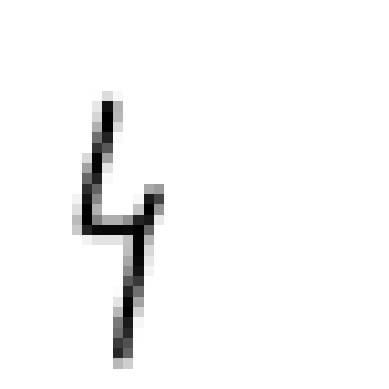

(36, 36, 1)


In [27]:
display_image(x_train[0])
print(x_train[0].shape)

In [33]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(36, 36, 1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(16, activation='softmax'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [34]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430,800 (1.64 MB)

 Trainable params: 430,224 (1.64 MB)

 Non-trainable params: 576 (2.25 KB)

In [35]:
history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/100


# Save Model

In [20]:
model.save('adv_model-2.h5')

# Load Model

In [43]:
loaded_model = load_model(r'adv_model.h5')

In [12]:
def preprocess_image(img_path, target_size=(28, 28)):
    img = Image.open(img_path).convert('L')
    img = img.resize(target_size)
    img_array = np.array(img).astype('float32') / 255.0
    img_array = img_array.reshape((1, target_size[0], target_size[1], 1))
    return img_array

In [11]:
def list_files_in_folder(base_folder):
    for root, dirs, files in os.walk(base_folder):
        for file in files:
            yield os.path.join(root, file)

In [13]:
# index_to_label = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add','dec'
#       'div', 'eq', 'mul', 'sub', 'x', 'y', 'z']
index_to_label = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'mul', 'sub', 'x', 'y', 'z']

In [7]:
def predict_image(img_path):
    img_array = preprocess_image(img_path)
    predictions = loaded_model.predict(img_array,verbose=0)
    predicted_class = np.argmax(predictions, axis=1)
    print(index_to_label[predicted_class[0]])

In [ ]:
base_folder = r'C:\Users\salos\MathPad-Solver\test-digit'
for file_path in list_files_in_folder(base_folder):
    img_array = preprocess_image(file_path)
    predictions = loaded_model.predict(img_array,verbose=0)
    predicted_class = np.argmax(predictions, axis=1)
    print(index_to_label[predicted_class[0]])

In [9]:
img_array = predict_image(r'C:\Users\salos\MathPad-Solver\recognition\custom_model\datasets\sub\xrCP3RgB.png')


sub
